<a href="https://colab.research.google.com/github/cccadet/dermatologist-ai/blob/master/01_Train1_ISIC_2019_model1_B7_divisao.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Pré: Conexão com Google Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Etapa 1: Instalação das dependências

### Instalação de bibliotecas

In [3]:
!pip install tensorflow-gpu
!pip install tqdm
#!pip install tensorflow-addons
!pip install tfa-nightly
!pip install deepstack

     |████████████████████████████████| 394.7MB 37kB/s 
     |████████████████████████████████| 716kB 4.3MB/s 


### Importação das bibliotecas

In [4]:
import zipfile
import os
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa

import matplotlib.pyplot as plt
import pandas as pd
import sys
import itertools
import shutil

from tqdm import tqdm_notebook
from tensorflow.keras.preprocessing.image import ImageDataGenerator

%matplotlib inline
tf.__version__

'2.4.0'

### Otimizações tensorflow

In [5]:
#from tensorflow.keras.mixed_precision import experimental as mixed_precision
#policy = mixed_precision.Policy('mixed_float16')
#mixed_precision.set_policy(policy)
tf.config.optimizer.set_jit(True)

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

### Fazendo o download da base de dados de imagens

In [6]:
%%time
if (os.path.isdir('./ISIC_Training_Input')==False):
  !wget --no-check-certificate \
      https://isic-challenge-data.s3.amazonaws.com/2018/ISIC2018_Task3_Training_Input.zip \
      -O ./skin_cancer_train_2018.zip


--2021-01-15 11:31:47--  https://isic-challenge-data.s3.amazonaws.com/2018/ISIC2018_Task3_Training_Input.zip
Resolving isic-challenge-data.s3.amazonaws.com (isic-challenge-data.s3.amazonaws.com)... 52.216.141.76
Connecting to isic-challenge-data.s3.amazonaws.com (isic-challenge-data.s3.amazonaws.com)|52.216.141.76|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2771732744 (2.6G) [application/zip]
Saving to: ‘./skin_cancer_train_2018.zip’

./skin_cancer_train 100%[===================>]   2.58G  13.0MB/s    in 48s     

2021-01-15 11:32:36 (54.9 MB/s) - ‘./skin_cancer_train_2018.zip’ saved [2771732744/2771732744]

CPU times: user 282 ms, sys: 109 ms, total: 391 ms
Wall time: 48.5 s


In [7]:
%%time
if (os.path.isdir('./ISIC_Training_Input')==False):
  !wget --no-check-certificate \
      https://s3.amazonaws.com/isic-challenge-data/2019/ISIC_2019_Training_Input.zip \
      -O ./skin_cancer_train_2019.zip

--2021-01-15 11:32:36--  https://s3.amazonaws.com/isic-challenge-data/2019/ISIC_2019_Training_Input.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.141.190
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.141.190|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9771618190 (9.1G) [application/zip]
Saving to: ‘./skin_cancer_train_2019.zip’

./skin_cancer_train 100%[===================>]   9.10G  29.8MB/s    in 4m 1s   

2021-01-15 11:36:37 (38.6 MB/s) - ‘./skin_cancer_train_2019.zip’ saved [9771618190/9771618190]

CPU times: user 1.23 s, sys: 458 ms, total: 1.69 s
Wall time: 4min 6s


## Etapa 2: Pré-processamento

### Configurando os caminhos (paths)

In [8]:
train_dir = "./train"
if not os.path.exists(train_dir): 
  os.mkdir(train_dir)
valid_dir = "./valid"
if not os.path.exists(valid_dir): 
  os.mkdir(valid_dir)


download_path = './'
derm_ai_path = '/content/drive/My Drive/Derm AI/ISIC_2019'


### Definindo função para descompactar arquivo

In [9]:
def dcp(download_path, path, file):
  if (os.path.isdir(path)==False):
    dataset_path = os.path.join(download_path,file)
    zip_object = zipfile.ZipFile(file=dataset_path, mode="r")
    zip_object.extractall("./")
    zip_object.close()

### Descompactando a base de dados de Treinamento

In [10]:
%%time
dcp(download_path, './ISIC2018_Task3_Training_Input', 'skin_cancer_train_2018.zip')

CPU times: user 7.32 s, sys: 5.04 s, total: 12.4 s
Wall time: 1min 23s


In [11]:
!rm ./skin_cancer_train_2018.zip

In [12]:
%%time
dcp(download_path, './ISIC_2019_Training_Input', 'skin_cancer_train_2019.zip')

CPU times: user 52.6 s, sys: 18.3 s, total: 1min 10s
Wall time: 4min 45s


In [13]:
!rm ./skin_cancer_train_2019.zip

### Definindo DataFrame base para criação das pastas de cada classe

In [14]:
!wget --no-check-certificate \
      https://isic-challenge-data.s3.amazonaws.com/2018/ISIC2018_Task3_Training_GroundTruth.zip \
      -O ./ground_truth.zip


zip_object = zipfile.ZipFile(file='ground_truth.zip', mode="r")
zip_object.extractall("./")
zip_object.close()

--2021-01-15 11:42:52--  https://isic-challenge-data.s3.amazonaws.com/2018/ISIC2018_Task3_Training_GroundTruth.zip
Resolving isic-challenge-data.s3.amazonaws.com (isic-challenge-data.s3.amazonaws.com)... 52.217.12.156
Connecting to isic-challenge-data.s3.amazonaws.com (isic-challenge-data.s3.amazonaws.com)|52.217.12.156|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 36681 (36K) [application/zip]
Saving to: ‘./ground_truth.zip’

./ground_truth.zip  100%[===================>]  35.82K  --.-KB/s    in 0.01s   

2021-01-15 11:42:53 (2.78 MB/s) - ‘./ground_truth.zip’ saved [36681/36681]



In [15]:
# Read in the data
ground_truth1 = pd.read_csv('https://s3.amazonaws.com/isic-challenge-data/2019/ISIC_2019_Training_GroundTruth.csv')
ground_truth2 = pd.read_csv('/content/ISIC2018_Task3_Training_GroundTruth/ISIC2018_Task3_Training_GroundTruth.csv')
ground_truth2['AK'] = ground_truth2['AKIEC']
ground_truth2.drop(columns=['AKIEC'], inplace=True)
ground_truth = pd.concat([ground_truth1,ground_truth2])
ground_truth = ground_truth.drop_duplicates(keep='first')

# Display some information in the dataset
ground_truth.head()

,image,MEL,NV,BCC,AK,BKL,DF,VASC,SCC,UNK
0,ISIC_0000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,ISIC_0000001,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,ISIC_0000002,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,ISIC_0000003,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,ISIC_0000004,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:
!mkdir ISIC_Training_Input
!mv /content/ISIC2018_Task3_Training_Input/*.jpg /content/ISIC_Training_Input
!mv /content/ISIC_2019_Training_Input/*.jpg /content/ISIC_Training_Input

### Separando base de treinamento e de validação

In [19]:
# Set y as the labels
y = []
for row in ground_truth.iterrows():
    innerlist = []
    newlist = row[1].index[row[1].values[1:].argmax() + 1]
    y.append(newlist)


#add a name to the label series
yd = pd.Series(y) 
yd.name = 'cclass'

#from sklearn.model_selection import train_test_split
#df_train, df_val = train_test_split(ground_truth, test_size=0.2, random_state=41, stratify=yd)
df_train_file = 'Dataset/df_train.csv'
df_val_file = 'Dataset/df_val.csv'
#df_train.to_csv(os.path.join(derm_ai_path, df_train_file), index=False)
#df_val.to_csv(os.path.join(derm_ai_path, df_val_file), index=False)
df_train = pd.read_csv(os.path.join(derm_ai_path, df_train_file))
df_val = pd.read_csv(os.path.join(derm_ai_path, df_val_file))

# Get a list of images in each of the two folders
folder = os.listdir('ISIC_Training_Input')

# Get a list of train and val images
#all_list = list(ground_truth['image'])
#
train_list = list(df_train['image'])
val_list = list(df_val['image'])

### Criando subdiretório das classes

In [20]:
#create sub directory for the classes
for col in ground_truth.columns:
    if not (col == 'image' or  col == 'UNK'):
        dir_path = os.path.join(train_dir, col)
        if not os.path.exists(dir_path):
          os.mkdir(dir_path)
        dir_path = os.path.join(valid_dir, col)
        if not os.path.exists(dir_path):
          os.mkdir(dir_path)

### Transferindo arquivos - base de treinamento

In [21]:
%%time
# Transfer the training images
for row in df_train.iterrows():
    image = row[1].image
    # The argmax error was occuring because the first column (image) is a string.
    # By using row[1].values[1:] we skip the first column.  This means we need 
    # add 1 to get the correct row[1].index.
    label = row[1].index[row[1].values[1:].argmax() + 1]
    fname = image + '.jpg'

    if fname in folder:
        # source path to image
        src = os.path.join('ISIC_Training_Input', fname)
        # destination path to image
        dst = os.path.join(train_dir, label, fname)
        # copy the image from the source to the destination
        shutil.copyfile(src, dst)

CPU times: user 17.2 s, sys: 16.7 s, total: 33.9 s
Wall time: 3min 54s


### Transferindo arquivos - base de validação

In [22]:
%%time
# Transfer the valid images
for row in df_val.iterrows():
    image = row[1].image
    # The argmax error was occuring because the first column (image) is a string.
    # By using row[1].values[1:] we skip the first column.  This means we need 
    # add 1 to get the correct row[1].index.
    label = row[1].index[row[1].values[1:].argmax() + 1]
    fname = image + '.jpg'

    if fname in folder:
        # source path to image
        src = os.path.join('ISIC_Training_Input', fname)
        # destination path to image
        dst = os.path.join(valid_dir, label, fname)
        # copy the image from the source to the destination
        shutil.copyfile(src, dst)

CPU times: user 4.09 s, sys: 4.33 s, total: 8.42 s
Wall time: 1min 3s


### Números das bases de treinamento

In [23]:
# training examples
total = 0
for col in ground_truth.columns:
    if not (col == 'image' or  col == 'UNK'):
        npath = os.path.join(train_dir, col)
        print(col,len(os.listdir(npath)))
        total = total+len(os.listdir(npath))
print('total = ',total)

MEL 3790
NV 11392
BCC 2749
AK 874
BKL 2277
DF 211
VASC 233
SCC 502
total =  22028


### Números das bases de validação

In [24]:
# validation examples
total = 0
for col in ground_truth.columns:
    if not (col == 'image' or  col == 'UNK'):
        npath = os.path.join(valid_dir, col)
        print(col,len(os.listdir(npath)))
        total = total+len(os.listdir(npath))
print('total = ',total)

MEL 1086
NV 3637
BCC 746
AK 231
BKL 701
DF 67
VASC 75
SCC 126
total =  6669


### Balanceamento base de validação

In [25]:
import os, random
mellen = len(os.listdir('./valid/MEL'))
nvlen = len(os.listdir('./valid/NV'))
for i in range(nvlen - mellen):
    file = random.choice(os.listdir("./valid/NV"))
    dst = os.path.join(valid_dir,'NV', file)
    os.remove(dst)

In [26]:
# validation examples
total = 0
for col in ground_truth.columns:
    if not (col == 'image' or  col == 'UNK'):
        npath = os.path.join(valid_dir, col)
        print(col,len(os.listdir(npath)))
        total = total+len(os.listdir(npath))
print('total = ',total)        
val_len = total

MEL 1086
NV 1086
BCC 746
AK 231
BKL 701
DF 67
VASC 75
SCC 126
total =  4118


AK
BCC
BKL
DF
MEL Melanoma
NV
SCC
VASC

### Criando pesos das classes

### Criando geradores de dados (Data Generators)


### Generators

In [27]:
# Data Augmentation (https://keras.io/preprocessing/image/)
data_gen_train = ImageDataGenerator(#validation_split=0.2,
                                    rescale=1/255., 
                                    horizontal_flip= True, 
                                    vertical_flip = True, 
                                    height_shift_range=0.10, 
                                    width_shift_range=0.10,
                                    rotation_range=180,
                                    shear_range=0.01,
                                    zoom_range=[0.95, 1.25],
                                    fill_mode='constant',
                                    #data_format='channels_last',
                                    brightness_range=[0.9, 1.1]
                                    )

data_gen_valid = ImageDataGenerator(rescale=1/255., 
                                   fill_mode="constant"
)



In [28]:
train_generator = data_gen_train.flow_from_directory(train_dir, target_size=(299,299), batch_size=16, class_mode="categorical")
valid_generator = data_gen_valid.flow_from_directory(valid_dir, target_size=(299,299), batch_size=16, class_mode="categorical")

Found 22028 images belonging to 8 classes.
Found 4118 images belonging to 8 classes.


### Exibição de 3 imagens carregadas

[1. 0. 0. 0. 0. 0. 0. 0.]


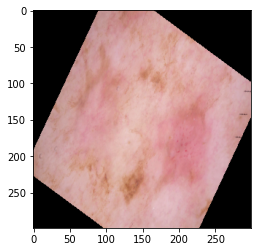

[0. 0. 0. 0. 0. 1. 0. 0.]


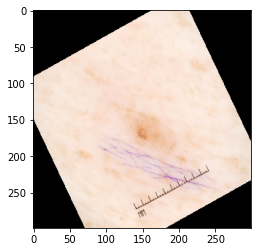

[0. 1. 0. 0. 0. 0. 0. 0.]


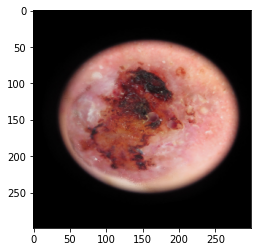

In [29]:
x,y = train_generator.next()
for i in range(0,3):
    image = x[i]
    label = y[i]
    print (label)
    plt.imshow(image)
    plt.show()

In [30]:
import numpy as np

from sklearn.utils import class_weight
class_weights = dict(zip(np.unique(train_generator.classes), class_weight.compute_class_weight('balanced',
                                                 np.unique(train_generator.classes),
                                                 train_generator.classes))) 


class_weights
train_generator.class_indices

{'AK': 0, 'BCC': 1, 'BKL': 2, 'DF': 3, 'MEL': 4, 'NV': 5, 'SCC': 6, 'VASC': 7}

## Etapa 3: Construindo o modelo

### Carregando o modelo pré-treinado (InceptionResNetV2)

In [31]:
img_shape = (299, 299, 3)
base_model = tf.keras.applications.EfficientNetB7(input_shape = img_shape, 
                                               include_top = False,
                                               weights = "imagenet")

base_model.trainable = False #@param {type:"boolean"}

258080768/258076736 [==============================] - 2s 0us/step


### Definindo o cabeçalho personalizado da rede neural

In [33]:
#base_model1
global_average_layer = tf.keras.layers.GlobalAveragePooling2D(name="gap")(base_model.output)
prediction_layer = tf.keras.layers.Dense(units = 8, activation = "softmax")(global_average_layer)
model = tf.keras.models.Model(inputs = base_model.input, outputs = prediction_layer)


In [34]:
radam = tfa.optimizers.RectifiedAdam(
    lr=1e-2,
    total_steps=len(train_generator),
    warmup_proportion=0.1,
    min_lr=1e-5)
ranger = tfa.optimizers.Lookahead(radam, sync_period=6, slow_step_size=0.5)

optm = ranger

model.compile(optimizer=optm, loss="categorical_crossentropy", metrics=[tf.keras.metrics.CategoricalAccuracy()])

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='categorical_accuracy', 
    verbose=1,
    patience=5,
    mode='max',
    restore_best_weights=True)

## Etapa 4: Treinamento

### Treinamento base_model congelado

In [35]:
%%time
model_filepath = os.path.join(derm_ai_path, 'model1_B7')

try:
  model.load_weights(model_filepath)
except:
  print('Sem pesos a carregar!')

callbacks_list = [
        tf.keras.callbacks.ModelCheckpoint(model_filepath, monitor='val_categorical_accuracy', verbose=1, save_best_only=True, save_weights_only=True)
    ]
model.fit(train_generator, epochs=2, callbacks=callbacks_list, validation_data=valid_generator)

Sem pesos a carregar!
Epoch 1/2
  21/1377 [..............................] - ETA: 3:19:26 - loss: 1.9418 - categorical_accuracy: 0.1024

KeyboardInterrupt: ignored

In [ ]:
%%time

base_model.trainable = True #@param {type:"boolean"}
model.compile(optimizer=optm, loss="categorical_crossentropy", metrics=[tf.keras.metrics.CategoricalAccuracy()])

try:
  model.load_weights(model_filepath)
except:
  print('Sem pesos a carregar!')

callbacks_list = [
        tf.keras.callbacks.ModelCheckpoint(model_filepath, monitor='val_categorical_accuracy', verbose=1, save_best_only=True)
    ]

model.fit(train_generator, epochs=10, callbacks=callbacks_list, validation_data=valid_generator)